In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd

In [2]:
import scipy.io as sio
data = sio.loadmat('data.mat')
train_TruePickups_flat = data['train_TruePickups_flat']
test_TruePickups_flat = data['test_TruePickups_flat']
print('train shape ', train_TruePickups_flat.shape)

train shape  (1, 107010)


In [3]:
print('train shape ', test_TruePickups_flat.shape)

train shape  (1, 26760)


In [4]:
train_TruePickups_flat = train_TruePickups_flat.reshape(107010,1)
test_TruePickups_flat = test_TruePickups_flat.reshape(26760,1)

In [5]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,2.0,0.0,31.0,26.0,4.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,5,11
1,0.0,31.0,26.0,4.0,14.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,5,10
2,31.0,26.0,4.0,14.0,37.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,5,29
3,26.0,4.0,14.0,37.0,21.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,5,26
4,4.0,14.0,37.0,21.0,13.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,5,15


In [6]:
test_data = pd.read_csv('test_data.csv')
test_data.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,25.0,4.0,42.0,0.0,38.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,1,25
1,4.0,42.0,0.0,38.0,4.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,1,15
2,42.0,0.0,38.0,4.0,14.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,1,10
3,0.0,38.0,4.0,14.0,8.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,1,10
4,38.0,4.0,14.0,8.0,4.0,0.000977,0.013916,0.006836,0.012939,0.00708,7080.667043,7060.950172,5326.119232,4815.488264,4805.713687,40.729715,-73.986412,1,5


LR

In [18]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_error", penalty = "l2") # squared_error
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

RF

In [21]:
def randomFor(train_data, train_true, test_data, test_true):
        #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    #hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [26]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(train_data, train_TruePickups_flat, test_data, test_TruePickups_flat)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(train_data, train_TruePickups_flat, test_data, test_TruePickups_flat)

In [27]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))

In [28]:
error_table_regressions

,Model,TrainMAPE(%),TrainMSE,TestMAPE(%),TestMSE
0,Linear Regression,[96.57741761742584],105.467749,[118.44802391840832],93.659675
0,Random Forest Regression,[35.26375142544144],18.371991,[102.83690276411113],83.600823


### LSTM 

In [7]:
train_std = StandardScaler().fit_transform(train_data)
test_std = StandardScaler().fit_transform(test_data)
train_std.shape

(107010, 19)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error
# 创建Sequential模型
model = Sequential()

# 添加LSTM层
model.add(LSTM(units=1024, input_shape=(19, 1)))

# 添加输出层
model.add(Dense(units=1))

# 编译模型
# model.compile(optimizer='adam', loss='mean_squared_error')

# 查看模型摘要
model.summary()
# 训练网络
verbose = 5
epochs = 100 # 训练周期
batch_size = 256 # 批次大小

# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("model.h5", monitor='val_mse', verbose=verbose, save_best_only=True, save_weights_only=False, mode='min') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=50, verbose=verbose)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='mse', optimizer='adam', metrics=['mse']) # 编译网络
# 训练模型
history = model.fit(train_std, train_TruePickups_flat, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size,
                    verbose=verbose, validation_data=(test_std, test_TruePickups_flat))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1024)              4202496   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,203,521
Trainable params: 4,203,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-24 14:15:40.358640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-05-24 14:15:45.683839: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_mse improved from inf to 91.09333, saving model to model.h5
Epoch 2/100

Epoch 2: val_mse did not improve from 91.09333
Epoch 3/100

Epoch 3: val_mse improved from 91.09333 to 89.44449, saving model to model.h5
Epoch 4/100

Epoch 4: val_mse improved from 89.44449 to 82.55454, saving model to model.h5
Epoch 5/100

Epoch 5: val_mse improved from 82.55454 to 75.47895, saving model to model.h5
Epoch 6/100

Epoch 6: val_mse improved from 75.47895 to 73.15208, saving model to model.h5
Epoch 7/100

Epoch 7: val_mse did not improve from 73.15208
Epoch 8/100

Epoch 8: val_mse improved from 73.15208 to 71.50598, saving model to model.h5
Epoch 9/100

Epoch 9: val_mse did not improve from 71.50598
Epoch 10/100

Epoch 10: val_mse did not improve from 71.50598
Epoch 11/100

Epoch 11: val_mse did not improve from 71.50598
Epoch 12/100

Epoch 12: val_mse did not improve from 71.50598
Epoch 13/100

Epoch 13: val_mse did not improve from 71.50598
Epoch 14/100

Epoch 14: val_mse did not imp

<IPython.core.display.Javascript object>


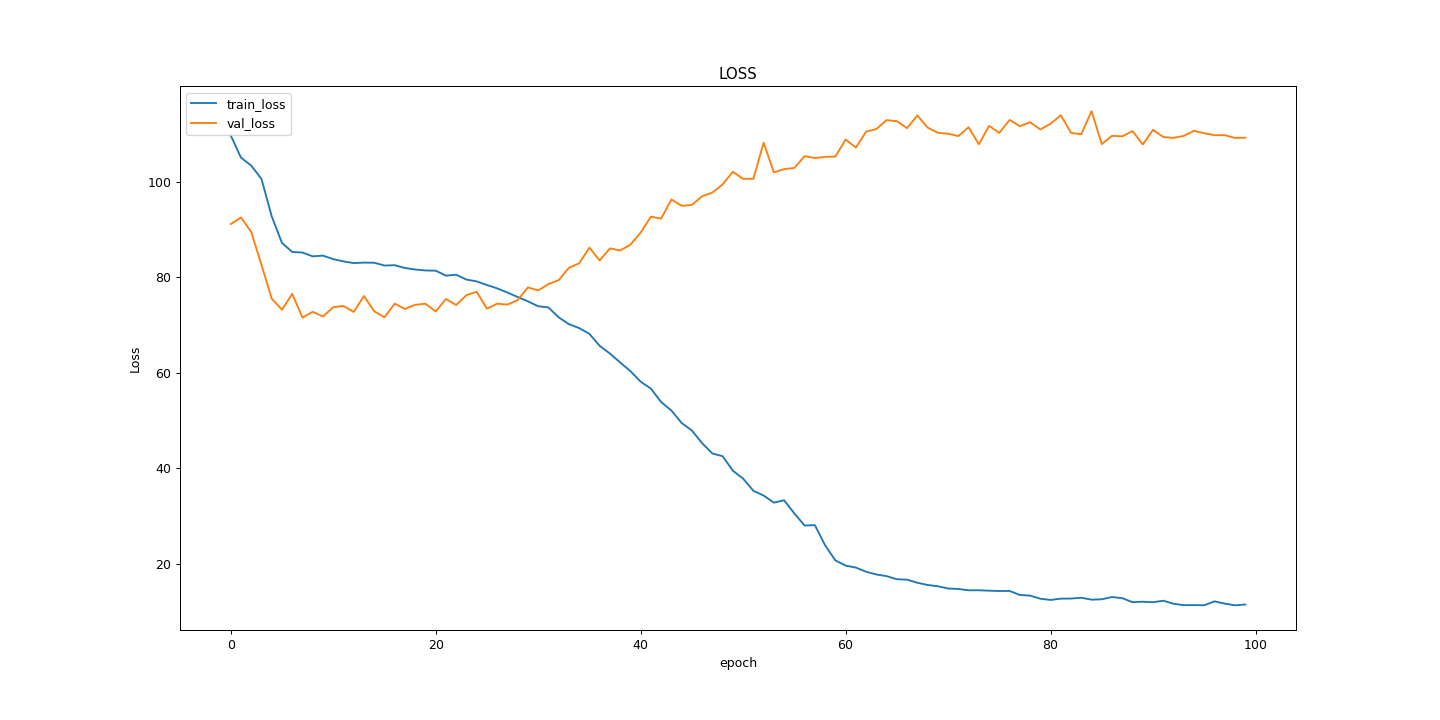

In [32]:
# 训练过程的训练集、测试集的损失值
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()
plt.show()

In [33]:
model = load_model('model.h5') 
y_train_pred = model.predict(train_std)
y_test_pred = model.predict(test_std)
print("Train data=> MSE: {:.4}".format(mean_squared_error(train_TruePickups_flat, y_train_pred)))
print("Test data=> MSE: {:.4} ".format(mean_squared_error(test_TruePickups_flat, y_test_pred)))

837/837 [==============================] - 2s 2ms/step
Train data=> MSE: 84.27
Test data=> MSE: 71.51 


In [58]:
from sklearn.metrics import mean_absolute_error
train_mape = mean_absolute_error(train_TruePickups_flat, y_train_pred)/ (sum(y_train_pred)/len(y_train_pred))
print("Train data=> MAPE: {:.4}".format(train_mape[0]))

test_mape = mean_absolute_error(test_TruePickups_flat, y_test_pred)/ (sum(y_test_pred)/len(y_test_pred))
print("Test data=> MAPE: {:.4} ".format(test_mape[0]))

Train data=> MAPE: 1.0
Test data=> MAPE: 0.7781 


### RNN 

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# 创建Sequential模型
model = Sequential()

# 添加RNN层
model.add(SimpleRNN(units=1024, input_shape=(19, 1)))

# 添加输出层
model.add(Dense(units=1))

# 编译模型
#model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# 查看模型摘要
verbose = 5
epochs = 100 # 训练周期
batch_size = 256 # 批次大小

# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("model_rnn.h5", monitor='val_mse', verbose=verbose, save_best_only=True, save_weights_only=False, mode='min') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=50, verbose=verbose)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='mse', optimizer='adam', metrics=['mse']) # 编译网络
# 训练模型
history = model.fit(train_std, train_TruePickups_flat, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size,
                    verbose=verbose, validation_data=(test_std, test_TruePickups_flat))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1024)              1050624   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,051,649
Trainable params: 1,051,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

Epoch 1: val_mse improved from inf to 98.88526, saving model to model_rnn.h5
Epoch 2/100

Epoch 2: val_mse did not improve from 98.88526
Epoch 3/100

Epoch 3: val_mse did not improve from 98.88526
Epoch 4/100

Epoch 4: val_mse did not improve from 98.88526
Epoch 5/100

Epoch 5: val_mse did not improve from 98.88526
Epoch 6/100

Epoch 6: val_mse did not improve from 98.88526
Epoch 7/100

Epoch 7: val_mse did not improve from

<IPython.core.display.Javascript object>


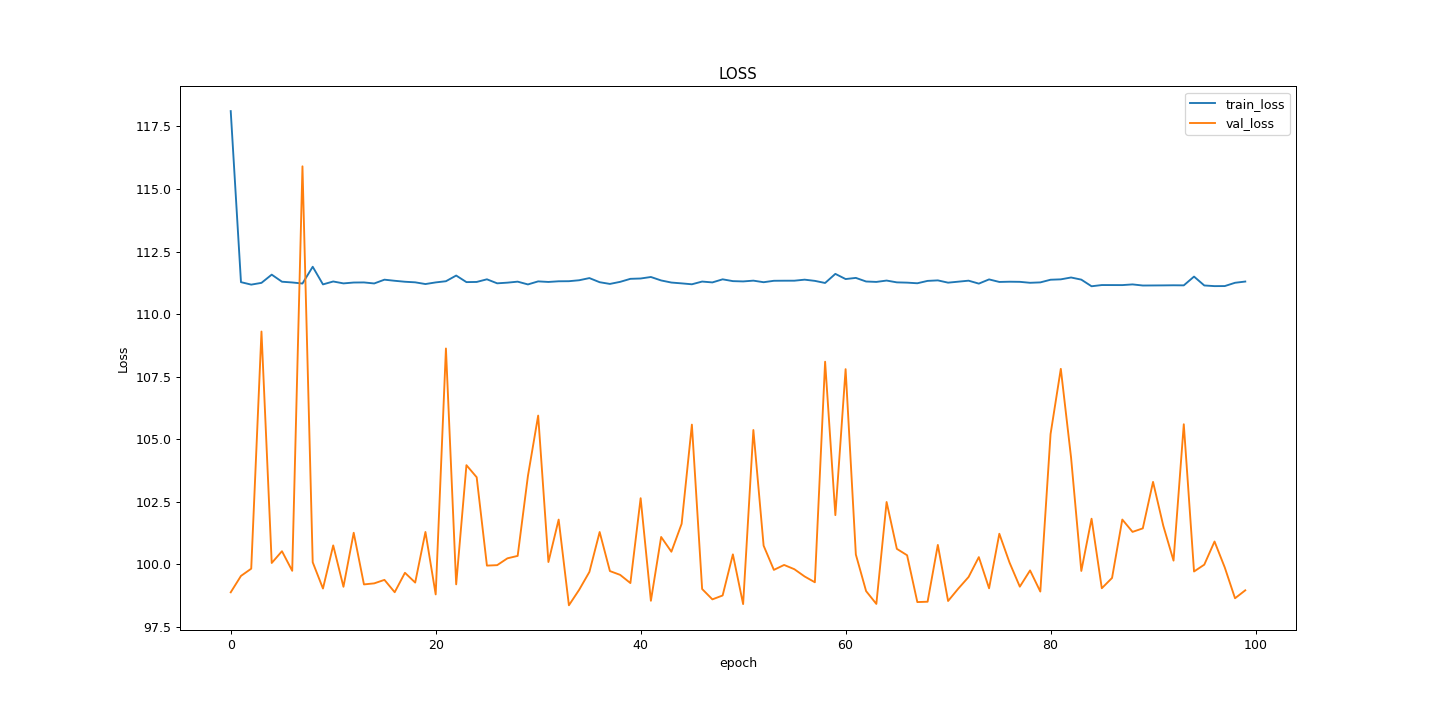

In [61]:
# 训练过程的训练集、测试集的损失值
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('LOSS')
plt.legend()
plt.show()

In [75]:
model = load_model('model_rnn.h5') 
y_train_pred = model.predict(train_std)
y_test_pred = model.predict(test_std)
print("Train data=> MSE: {:.4}".format(mean_squared_error(train_TruePickups_flat, y_train_pred)))
print("Test data=> MSE: {:.4} ".format(mean_squared_error(test_TruePickups_flat, y_test_pred)))

837/837 [==============================] - 7s 8ms/step
Train data=> MSE: 113.5
Test data=> MSE: 98.37 


In [65]:
from sklearn.metrics import mean_absolute_error
train_mape = mean_absolute_error(train_TruePickups_flat, y_train_pred)/ (sum(y_train_pred)/len(y_train_pred))
print("Train data=> MAPE: {:.4}".format(train_mape[0]))

test_mape = mean_absolute_error(test_TruePickups_flat, y_test_pred)/ (sum(y_test_pred)/len(y_test_pred))
print("Test data=> MAPE: {:.4} ".format(test_mape[0]))

Train data=> MAPE: 1.0
Test data=> MAPE: 1.155 


### GBDT

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100)
model.fit(train_std, train_TruePickups_flat)

y_train_pred = model.predict(train_std)
y_test_pred = model.predict(test_std)
print("Train data=> MSE: {:.4}".format(mean_squared_error(train_TruePickups_flat, y_train_pred)))
print("Test data=> MSE: {:.4} ".format(mean_squared_error(test_TruePickups_flat, y_test_pred)))

Train data=> MSE: 84.42
Test data=> MSE: 81.8 


In [79]:
train_mape = mean_absolute_error(train_TruePickups_flat, y_train_pred)/ (sum(y_train_pred)/len(y_train_pred))
print("Train data=> MAPE: {:.4}".format(train_mape))

test_mape = mean_absolute_error(test_TruePickups_flat, y_test_pred)/ (sum(y_test_pred)/len(y_test_pred))
print("Test data=> MAPE: {:.4} ".format(test_mape))

Train data=> MAPE: 0.8136
Test data=> MAPE: 0.7931 


### SVR

In [8]:
from sklearn.svm import SVR
model = SVR(kernel='linear', C=1.0, epsilon=0.1, verbose=5)

model.fit(train_std, train_TruePickups_flat)

y_train_pred = model.predict(train_std)
y_test_pred = model.predict(test_std)
print("Train data=> MSE: {:.4}".format(mean_squared_error(train_TruePickups_flat, y_train_pred)))
print("Test data=> MSE: {:.4} ".format(mean_squared_error(test_TruePickups_flat, y_test_pred)))

[LibSVM]...................................................................................................................................................................................................*.............*................................................................................*...........................................................................*..........................................................................*
optimization finished, #iter = 437148
obj = -702554.997060, rho = -4.826093
nSV = 105047, nBSV = 105006
Train data=> MSE: 108.4
Test data=> MSE: 86.57 


In [9]:
train_mape = mean_absolute_error(train_TruePickups_flat, y_train_pred)/ (sum(y_train_pred)/len(y_train_pred))
print("Train data=> MAPE: {:.4}".format(train_mape))

test_mape = mean_absolute_error(test_TruePickups_flat, y_test_pred)/ (sum(y_test_pred)/len(y_test_pred))
print("Test data=> MAPE: {:.4} ".format(test_mape))

Train data=> MAPE: 1.381
Test data=> MAPE: 1.234 
